In [1]:
import tqdm
import numpy as np
import scipy.stats
import sklearn
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('ticks')
palette = sns.color_palette("RdBu_r", n_colors=25)

import ulsif

In [2]:
tmis = [-0.5 * np.log(1 - c**2) for c in np.arange(0, 1, 0.1)]

In [4]:
n = 1000
cov = np.array([[1, 0.5], [0.5, 1]])
XY = scipy.stats.multivariate_normal(mean=[0, 0], cov=cov).rvs(n)
X, Y = np.split(XY, [1], axis=1)

In [ ]:
cv = ulsif.MutualInformationCV()
cv.fit(X, Y)

In [8]:
mis = []
for c in tqdm.tqdm(np.arange(0, 1, 0.1)):
    cov = np.array([[1, c], [c, 1]])
    XY = scipy.stats.multivariate_normal(mean=[0, 0], cov=cov).rvs(n)
    X, Y = np.split(XY, [1], axis=1)
#     mis += [ulsif.MutualInformationCV().fit(X, Y).mi]
    mis += [ulsif.MutualInformation(lamb=1e-4, sigma=1).fit(X, Y).mi]

100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


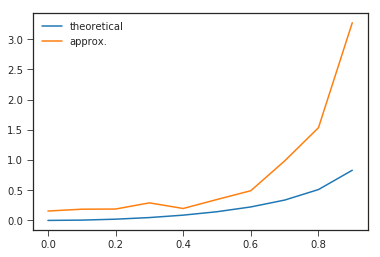

In [9]:
plt.plot(np.arange(0, 1, 0.1), tmis, label='theoretical')
plt.plot(np.arange(0, 1, 0.1), mis, label='approx.')
plt.legend()